In [2]:
# Import Libraries
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import os
import glob
import matplotlib.pyplot as plt
# Keras API
import keras
from keras.models import Sequential
from keras.layers import Dense,Dropout,Flatten
from keras.layers import Conv2D,MaxPooling2D,Activation,AveragePooling2D,BatchNormalization
from keras.preprocessing.image import ImageDataGenerator

In [4]:
train_dir = "cell_images/Train"
test_dir = "cell_images/Test"

In [5]:
# function to get count of images
def get_files(directory):
  if not os.path.exists(directory):
    return 0
  count=0
  for current_path,dirs,files in os.walk(directory):
    for dr in dirs:
      count+= len(glob.glob(os.path.join(current_path,dr+"/*")))
  return count

In [6]:
train_samples =get_files(train_dir)
num_classes=len(glob.glob(train_dir+"/*"))
test_samples=get_files(test_dir) # For testing i took only few samples from unseen data. we can evaluate using validation data which is part of train data.
print(num_classes,"Classes")
print(train_samples,"Train images")
print(test_samples,"Test images")

2 Classes
27594 Train images
1067 Test images


In [8]:
# Preprocessing data.
train_datagen=ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   validation_split=0.2, # validation split 20%.
                                   horizontal_flip=True)
test_datagen=ImageDataGenerator(rescale=1./255)

In [9]:
# set height and width and color of input image.
img_width,img_height =256,256
input_shape=(img_width,img_height,3)
batch_size =32

train_generator =train_datagen.flow_from_directory(train_dir,
                                                   target_size=(img_width,img_height),
                                                   batch_size=batch_size)
test_generator=test_datagen.flow_from_directory(test_dir,shuffle=True,
                                                   target_size=(img_width,img_height),
                                                   batch_size=batch_size)

Found 27592 images belonging to 2 classes.
Found 1067 images belonging to 2 classes.


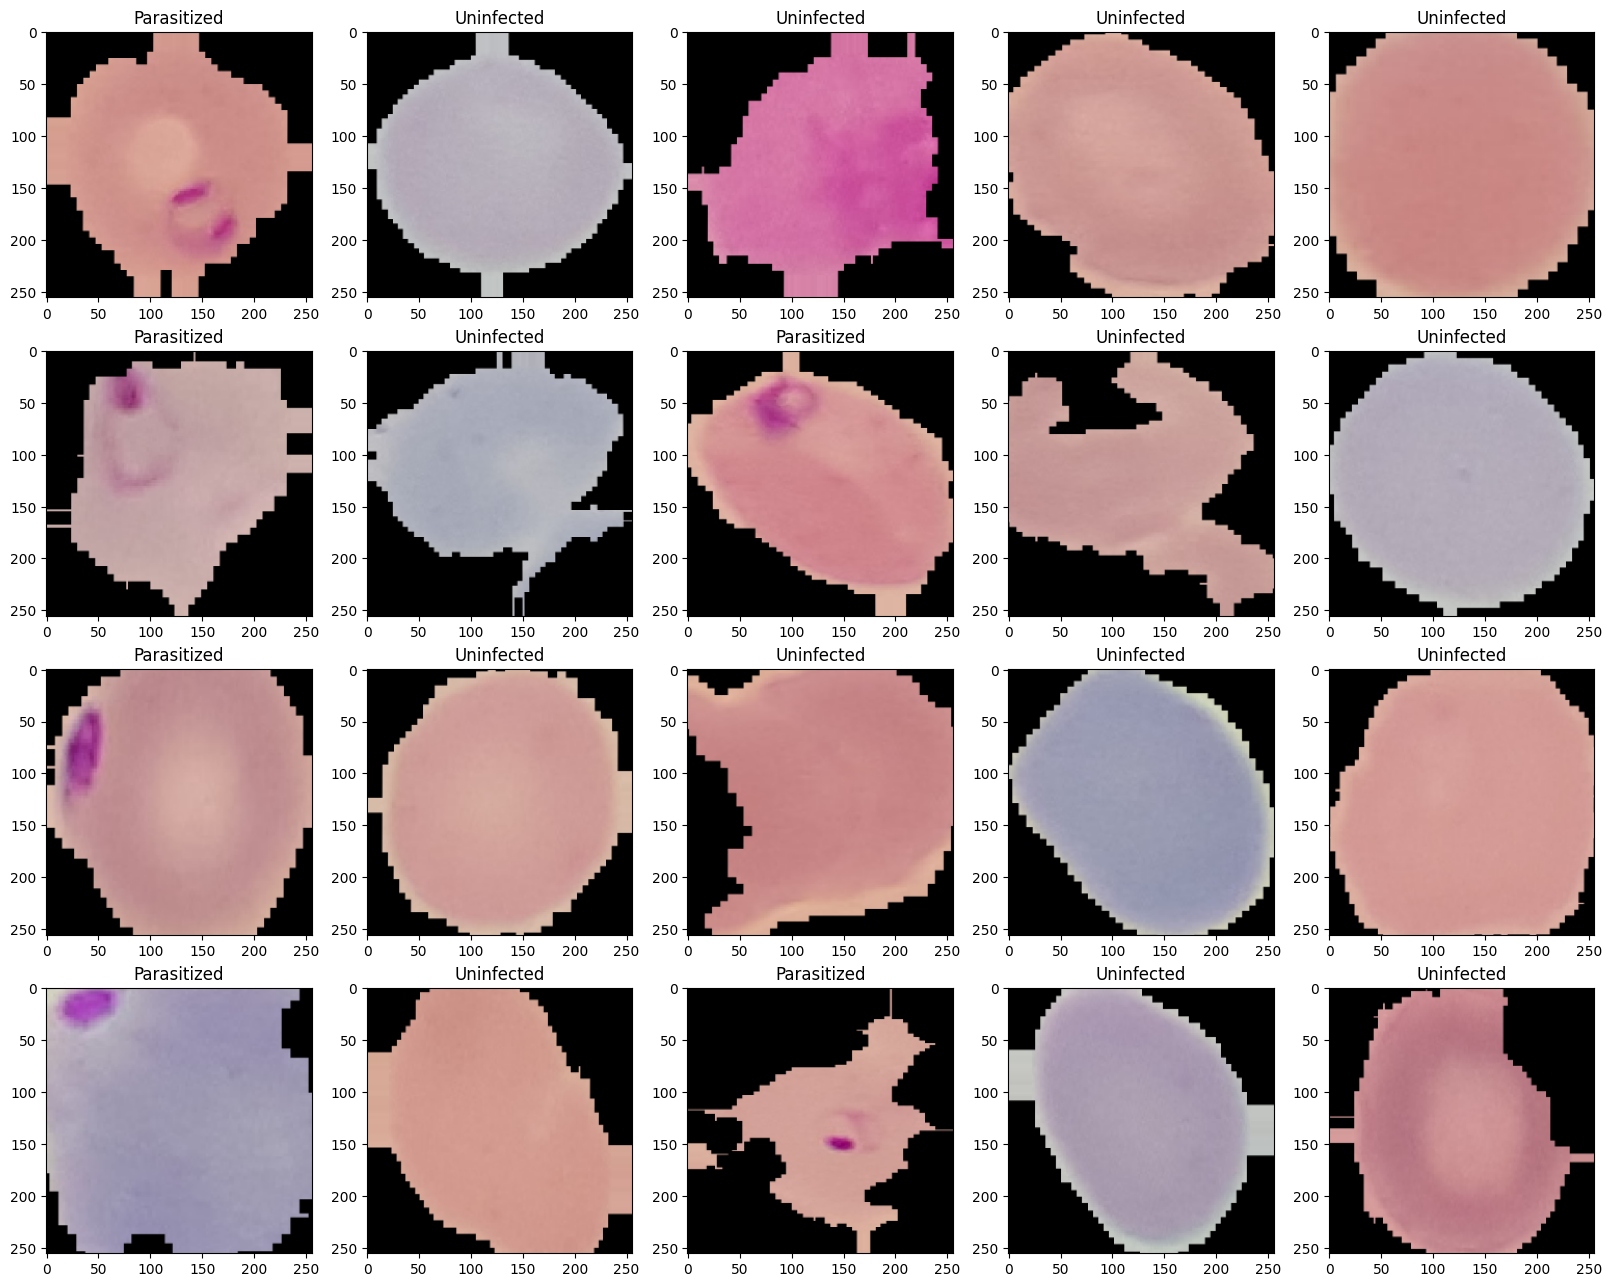

In [10]:
classes=list(train_generator.class_indices.keys())
plt.figure(figsize=(20,20))
for X_batch, y_batch in train_generator:
    for i in range(0,20):
        plt.subplot(5,5,i+1)
        plt.imshow(X_batch[i])
        plt.title(classes[np.where(y_batch[i]==1)[0][0]])
    plt.show()
    break

In [11]:
diseases = os.listdir(train_dir)
nums = {}
for disease in diseases:
    nums[disease] = len(os.listdir(train_dir + '/' + disease))
img_per_class = pd.DataFrame(nums.values(), index=nums.keys(), columns=["no. of images"])
img_per_class


,no. of images
Parasitized,13780
Uninfected,13814


Text(0.5, 1.0, 'Images per each class')

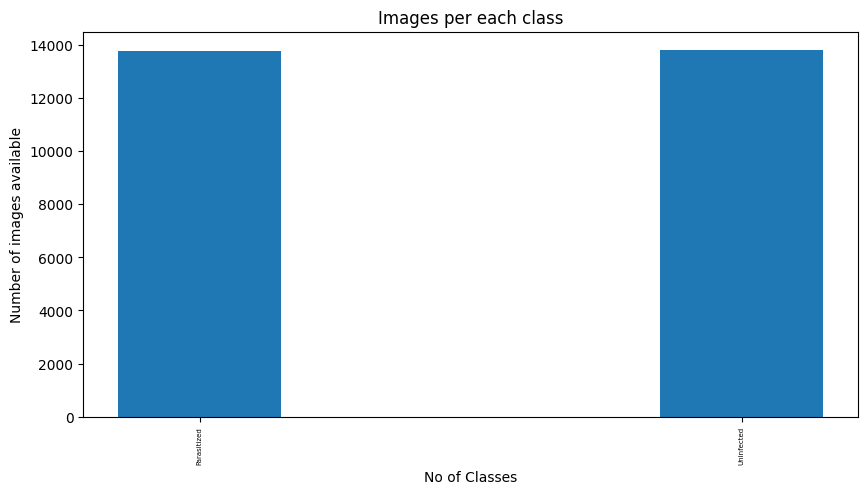

In [12]:
index = [n for n in range(2)]
plt.figure(figsize=(10, 5))
plt.bar(index, [n for n in nums.values()], width=0.3)
plt.xlabel('No of Classes', fontsize=10)
plt.ylabel('Number of images available', fontsize=10)
plt.xticks(index, diseases, fontsize=5, rotation=90)
plt.title('Images per each class')

In [11]:
# CNN building.
model = Sequential()
model.add(Conv2D(32, (5, 5),input_shape=input_shape,activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Conv2D(32, (3, 3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))   
model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(128,activation='relu'))          
model.add(Dense(num_classes,activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 252, 252, 32)      2432      
                                                                 
 max_pooling2d (MaxPooling2  (None, 84, 84, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 82, 82, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 41, 41, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 39, 39, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 19, 19, 64)        0

In [12]:
model_layers = [ layer.name for layer in model.layers]
print('layer name : ',model_layers)

layer name :  ['conv2d', 'max_pooling2d', 'conv2d_1', 'max_pooling2d_1', 'conv2d_2', 'max_pooling2d_2', 'flatten', 'dense', 'dropout', 'dense_1', 'dense_2']


In [13]:
# validation data.
validation_generator = train_datagen.flow_from_directory(
    train_dir, # same directory as training data
    target_size=(img_height, img_width),
    batch_size=batch_size) 

Found 27592 images belonging to 2 classes.


In [14]:
opt = keras.optimizers.Adam(lr=0.001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
train = model.fit(train_generator,
                  epochs=10,
                  steps_per_epoch=train_generator.samples // batch_size,
                  validation_data=validation_generator,
                  validation_steps=validation_generator.samples // batch_size,
                  verbose=1)


Epoch 1/10
862/862 [==============================] - 833s 965ms/step - loss: 0.5378 - accuracy: 0.7003 - val_loss: 0.1924 - val_accuracy: 0.9319
Epoch 2/10
862/862 [==============================] - 827s 959ms/step - loss: 0.1737 - accuracy: 0.9442 - val_loss: 0.1556 - val_accuracy: 0.9529
Epoch 3/10
862/862 [==============================] - 832s 965ms/step - loss: 0.1528 - accuracy: 0.9520 - val_loss: 0.1532 - val_accuracy: 0.9556
Epoch 4/10
862/862 [==============================] - 851s 987ms/step - loss: 0.1460 - accuracy: 0.9548 - val_loss: 0.1344 - val_accuracy: 0.9566
Epoch 5/10
862/862 [==============================] - 20908s 24s/step - loss: 0.1387 - accuracy: 0.9557 - val_loss: 0.1446 - val_accuracy: 0.9494
Epoch 6/10
862/862 [==============================] - 818s 949ms/step - loss: 0.1375 - accuracy: 0.9566 - val_loss: 0.1292 - val_accuracy: 0.9587
Epoch 7/10
862/862 [==============================] - 796s 923ms/step - loss: 0.1304 - accuracy: 0.9579 - val_loss: 0.1230 -

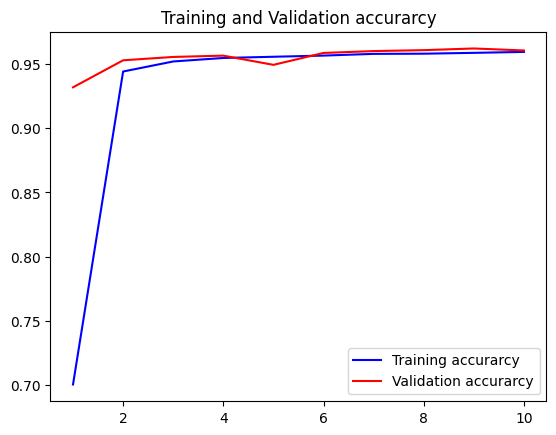

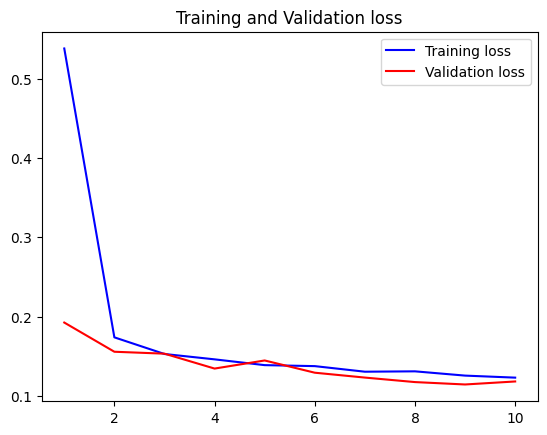

In [15]:
accuracy = train.history['accuracy']
val_acc = train.history['val_accuracy']
loss = train.history['loss']
val_loss = train.history['val_loss']
epochs = range(1, len(accuracy) + 1)
#Train and validation accuracy
plt.plot(epochs, accuracy, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [16]:
score, accuracy = model.evaluate(test_generator, verbose=1)
print("Test score is {}".format(score))
print("Test accuracy is {:.2f}%".format(accuracy * 100))

34/34 [==============================] - 10s 299ms/step - loss: 0.0838 - accuracy: 0.9728
Test score is 0.08380395174026489
Test accuracy is 97.28%


In [17]:
# Get classes of model trained on
classes = train_generator.class_indices 
classes

{'Parasitized': 0, 'Uninfected': 1}

In [18]:
# Save entire model with optimizer, architecture, weights and training configuration.
from keras.models import load_model
model.save('Malaria.h5')

1/1 [==============================] - 0s 129ms/step


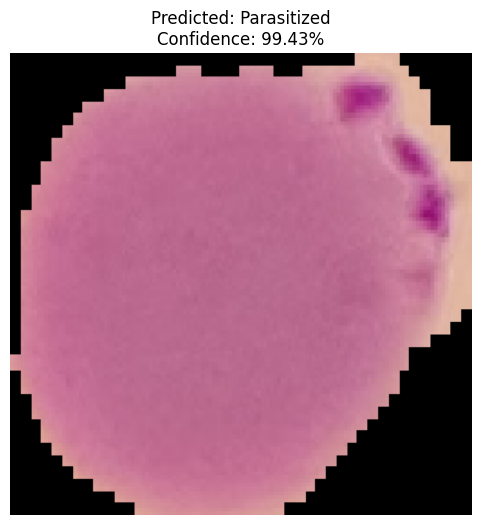

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# Load the model (replace 'model_path' with the actual path to your trained model)
model = tf.keras.models.load_model('malaria.h5')

# Load the class names
class_names = ['Parasitized','Uninfected']  # Replace with your actual class names

# Load and preprocess the input image
img_path = "cell_images/Test/Parasitized/C59P20thinF_IMG_20150803_112802_cell_166.png"
img = image.load_img(img_path, target_size=(256, 256))
img_array = image.img_to_array(img)
img_array = img_array / 255.0  # Normalize the pixel values
input_img = np.expand_dims(img_array, axis=0)

# Make a prediction using the model
predictions = model.predict(input_img)
predicted_class_index = np.argmax(predictions)
predicted_class = class_names[predicted_class_index]
confidence = predictions[0][predicted_class_index] * 100.0

# Display the input image and prediction
plt.figure(figsize=(6, 6))
plt.imshow(img)
plt.title(f"Predicted: {predicted_class}\nConfidence: {confidence:.2f}%")
plt.axis("off")
plt.show()


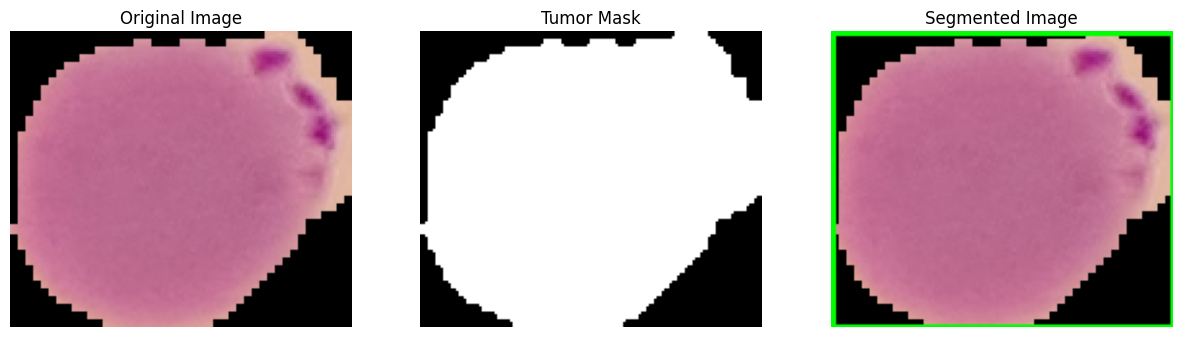

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def segment_brain_tumor(image_path):
    # Read the input image
    img = cv2.imread(image_path)
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Preprocess the image (e.g., apply Gaussian blur, thresholding)
    blurred = cv2.GaussianBlur(img_gray, (5, 5), 0)
    _, thresholded = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # Find contours in the thresholded image
    contours, _ = cv2.findContours(thresholded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Create a mask for the tumor region
    tumor_mask = np.zeros_like(img_gray)
    for contour in contours:
        area = cv2.contourArea(contour)
        if area > 1000:  # Adjust threshold as needed
            cv2.drawContours(tumor_mask, [contour], -1, (255), thickness=cv2.FILLED)
    
    # Apply the mask to the original image
    segmented_image = cv2.bitwise_and(img, img, mask=tumor_mask)
    
    # Draw bounding box around the tumor region
    x, y, w, h = cv2.boundingRect(tumor_mask)
    cv2.rectangle(segmented_image, (x, y), (x + w, y + h), (0, 255, 0), 2)
    
    return img, tumor_mask, segmented_image

# Load the trained model
# Replace 'model_path' with the actual path to your trained model
model_path = 'malaria.h5'
model = cv2.dnn.readNetFromTensorflow(model_path)

# Example usage
image_path = "cell_images/Test/Parasitized/C59P20thinF_IMG_20150803_112802_cell_166.png"
original_image, tumor_mask, segmented_image = segment_brain_tumor(image_path)

# Display the preprocessed image, mask image, and segmented image
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(tumor_mask, cmap='gray')
plt.title("Tumor Mask")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(segmented_image, cv2.COLOR_BGR2RGB))
plt.title("Segmented Image")
plt.axis("off")

plt.show()
